In [94]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [95]:
def LSTM_train_load(train_path, inp_len, indices, denormalize=False):
    
    pkl_list = glob(os.path.join(train_path, '*'))
    pkl_list.sort()
    
    data = []
    label = []

    for i in indices:
        with open(pkl_list[i], 'rb') as f:
            scene = pickle.load(f)

        min_vecs = scene['normalize_min']  
        max_vecs = scene['normalize_max']

        inp = scene['inp_scene'][:, :2]
        out = scene['out_scene'][:, :2]
        init = inp[0, :]
        
        inp = inp - init
        out = out - init

        if denormalize:
            inp = inp * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
            out = out * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
        
        temp = np.concatenate((inp, out), axis=0)

        for j in range(temp.shape[0] - inp_len - 1):
            data.append(temp[j:j+inp_len])
            label.append(temp[j+1:j+inp_len+1])

    data = np.array(data)
    label = np.array(label)

    return data, label

In [96]:
LSTM_path = "./../data/prep_1/train"
# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:10]
input_len = 19

# load data
LSTM_data, LSTM_label = LSTM_train_load(LSTM_path, input_len, train_indices, denormalize=False)

In [97]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, output_size)
        self.fcn = nn.Sequential(
            nn.Linear(hidden_size, 600),
            nn.ReLU(),
            nn.Linear(600, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),            
        )
        self.fcn2 = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.ReLU(),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        out, _ = self.lstm(x, (h0, c0))
        # out, _ = self.rnn(x, h0)
        out.contiguous().view(-1, self.hidden_size)  
        # out = self.fc(out) 
        out = self.fcn(out)
        out, _ = self.lstm(out, (h0, c0))
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fcn2(out)
        out = out.view(x.size(0), -1, 2)
        return out

In [98]:
# LSTM Hyperparameters
input_size = 2
hidden_size = 200
num_layers = 4
seq_len = input_len
output_size = 2

baseline = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [92]:
critertion = nn.MSELoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)

In [99]:
# Print the model architecture in the form of propogation forward
print(baseline)

LSTM(
  (lstm): LSTM(2, 200, num_layers=4, batch_first=True)
  (fcn): Sequential(
    (0): Linear(in_features=200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
  (fcn2): Sequential(
    (0): Linear(in_features=200, out_features=2, bias=True)
    (1): ReLU()
  )
)


In [100]:
epochs = 100

for epoch in range(epochs):
    start = time.time()
    baseline.train()
    train_mse = []
    for i in range(LSTM_data.shape[0]):
        optimizer.zero_grad()
        inp = torch.tensor(LSTM_data[i]).float().to(device)
        inp = inp.view(-1, seq_len, input_size)
        label = torch.tensor(LSTM_label[i]).float().to(device)
        label = label.view(-1, seq_len, output_size)
        pred = baseline(inp).to(device)
        loss = critertion(pred.view(-1, output_size), label.view(-1, output_size))
        loss.backward()
        optimizer.step()
        train_mse.append(loss.item())
    train_rmse = round(np.sqrt(np.mean(train_mse)),5)
    
    print("Epoch: {}, Loss: {}, Time: {}".format(epoch, train_rmse, time.time() - start))    

KeyboardInterrupt: 

In [75]:
out_len = 30
baseline.eval()
out = []

with torch.no_grad():
    for i in range(LSTM_data.shape[0]):
        out_test = LSTM_data[i]
        inp = torch.tensor(out_test).float().to(device)
        inp = inp.view(-1, seq_len, input_size)
        print(inp)

        for j in range(out_len):
            pred = baseline(inp).to(device)
            inp = torch.cat((inp[:, 1:, :], pred[:, -1, :].view(-1, 1, output_size)), dim=1)
            out_test = np.concatenate((out_test, pred[:, -1, :].cpu().numpy()), axis=0)
        out.append(out_test)

tensor([[[0.0000, 0.0000],
         [0.0001, 0.0002],
         [0.0002, 0.0003],
         [0.0003, 0.0004],
         [0.0004, 0.0004],
         [0.0005, 0.0005],
         [0.0006, 0.0007],
         [0.0008, 0.0010],
         [0.0009, 0.0012],
         [0.0010, 0.0012],
         [0.0011, 0.0013],
         [0.0012, 0.0015],
         [0.0013, 0.0016],
         [0.0014, 0.0018],
         [0.0015, 0.0019],
         [0.0017, 0.0022],
         [0.0017, 0.0022],
         [0.0019, 0.0025],
         [0.0020, 0.0026]]])
tensor([[[0.0001, 0.0002],
         [0.0002, 0.0003],
         [0.0003, 0.0004],
         [0.0004, 0.0004],
         [0.0005, 0.0005],
         [0.0006, 0.0007],
         [0.0008, 0.0010],
         [0.0009, 0.0012],
         [0.0010, 0.0012],
         [0.0011, 0.0013],
         [0.0012, 0.0015],
         [0.0013, 0.0016],
         [0.0014, 0.0018],
         [0.0015, 0.0019],
         [0.0017, 0.0022],
         [0.0017, 0.0022],
         [0.0019, 0.0025],
         [0.0020, 0.0026],

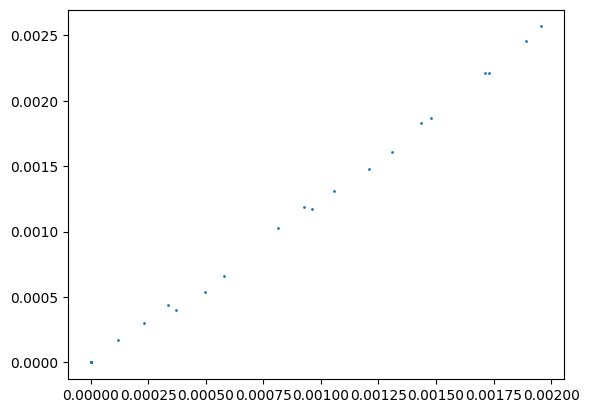

In [76]:
plt.scatter(out[0][:, 0], out[0][:, 1], s=1)

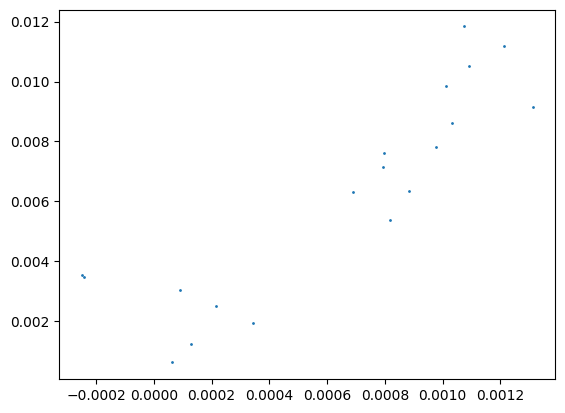